# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2024/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 5th, 2024 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 


# Part 1: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

# Part 2: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2 and 3.

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

# Part 3: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

# Artist Genre Sentiment Network Analysis

## Introduction
In this notebook, we will analyze the sentiment associated with various music genres for different artists. We will construct a network graph where nodes represent artists and genres, and edges connect artists to the genres they belong to. The sentiment scores will influence the size and color of the artist nodes in the graph.

## Requirements
Make sure you have the following libraries installed:


In [20]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize



## Loading Data
1. Load Genres Data
We will load artist genre data from a JSON-like text file.



In [21]:
# Load the genres data from a txt file assuming the file follows a JSON-like structure
file_path = '/workspaces/SocialGraphs/Assignment2/genres.txt'

# Reading and loading the JSON data
with open(file_path, 'r') as file:
    artist_data = json.load(file)  # Directly load into a dictionary


## 2. Load Sentiment Data
Next, we will load sentiment data from a tab-delimited text file.



In [22]:
# Load sentiment data from a .txt file with tab as the delimiter
file_path = '/workspaces/SocialGraphs/Assignment2/Data_Set_S1.txt'  # Change this to your actual file path
sentiment_df = pd.read_csv(file_path, sep='\t', skiprows=2)  # Skip the first two lines


# 3. Create a Sentiment Dictionary
We'll create a dictionary to look up sentiment scores for each genre.

In [23]:
# Create a dictionary for sentiment lookup
sentiment_dict = dict(zip(sentiment_df['word'], sentiment_df['happiness_rank'].astype(int)))


# Calculating Sentiment Scores
We'll calculate average sentiment scores for each artist based on their associated genres

In [24]:
# Calculate sentiment scores for each artist based on genres
artist_sentiment_scores = {}
for artist, genres in artist_data.items():
    scores = []
    for genre in genres:
        # Check if the genre is in the sentiment dictionary
        if genre in sentiment_dict:
            scores.append(sentiment_dict[genre])
    
    # Calculate average score if scores are available
    if scores:
        average_score = np.mean(scores)
    else:
        average_score = 0  # Or any default value

    artist_sentiment_scores[artist] = average_score


# Creating the Network Graph
Now, we will create a network graph using NetworkX.

In [25]:
# Create a network graph
G = nx.Graph()

# Add artist nodes with sentiment scores
for artist, score in artist_sentiment_scores.items():
    G.add_node(artist, score=score)

# Add edges between artists and genres
for artist, genres in artist_data.items():
    for genre in genres:
        G.add_node(genre)
        G.add_edge(artist, genre)


# Visualizing the Network Graph
We will now visualize the network graph with appropriate node sizes and colors based on sentiment scores.

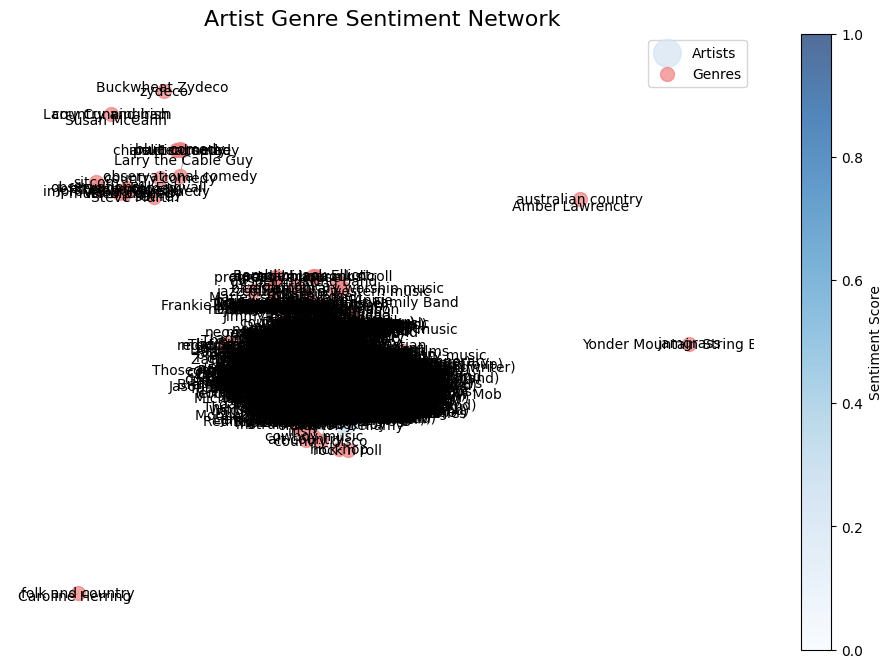

In [26]:
# Draw the network
plt.figure(figsize=(12, 8))  # Increase figure size
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# Normalize node sizes based on sentiment scores
max_score = max(artist_sentiment_scores.values(), default=1)
node_sizes = [G.nodes[node]['score'] / max_score * 800 for node in G.nodes if node in artist_sentiment_scores]

# Ensure only artist nodes are being processed for colors and sizes
artist_nodes = [node for node in G.nodes if node in artist_sentiment_scores]
genre_nodes = [node for node in G.nodes if node not in artist_sentiment_scores]

# Create color map for artist nodes based on sentiment scores
colors = [G.nodes[node]['score'] / max_score for node in artist_nodes]  # Normalize scores for color mapping
norm = Normalize(vmin=0, vmax=1)  # Normalization for color mapping

# Draw nodes
sc = nx.draw_networkx_nodes(G, pos, nodelist=artist_nodes, node_color=colors, cmap=plt.cm.Blues, 
                             node_size=node_sizes, alpha=0.7, label="Artists")

# Draw genre nodes
nx.draw_networkx_nodes(G, pos, nodelist=genre_nodes, node_color='lightcoral', node_size=100, alpha=0.7, label="Genres")

# Draw edges with improved transparency
nx.draw_networkx_edges(G, pos, alpha=0.4, width=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color='black')

# Add a colorbar
cbar = plt.colorbar(sc, label='Sentiment Score')  # Colorbar for sentiment scores

# Additional plot settings
plt.axis('off')  # Hide the axis
plt.legend()  # Show legend
plt.title("Artist Genre Sentiment Network", fontsize=16)
plt.show()


# Part 2
## Creating Sentiment Scores for Artists

Here, we calculate average sentiment scores for each artist based on their associated genres.

In [27]:
artist_sentiment_scores = {}
for artist, genres in artist_data.items():
    scores = [sentiment_dict[genre] for genre in genres if genre in sentiment_dict]
    artist_sentiment_scores[artist] = np.mean(scores) if scores else 0


## Building the Network Graph and Detecting Communities
Now, we construct the artist-genre network graph and use the Louvain method for community detection to identify the largest communities.This algorithm progressively removes edges with the highest betweenness centrality, splitting the graph into communities.



In [28]:
# Creating the graph
G = nx.Graph()

# Adding artist nodes and sentiment scores
for artist, score in artist_sentiment_scores.items():
    G.add_node(artist, score=score)

# Adding edges between artists and genres
for artist, genres in artist_data.items():
    for genre in genres:
        G.add_node(genre)
        G.add_edge(artist, genre)

# Use community detection to find the largest communities
import community_louvain
partition = community_louvain.best_partition(G)

# Identify the largest communities by size
community_counter = Counter(partition.values())
largest_communities = community_counter.most_common(5)
print("Largest communities:", largest_communities)


ModuleNotFoundError: No module named 'community_louvain'